In [27]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
%matplotlib inline
import pandas as pd
import tensorflow as tf
import glob
import os
import matplotlib.ticker as ticker
import seaborn
seaborn.set_context('paper', font_scale=1.5)

In [28]:
from tensorflow.python.summary.summary_iterator import summary_iterator

In [29]:
def mean_(val, freq):
    return np.average(val, weights = freq)

def median_(val, freq):
    return quantile_(val, freq, a = 0.5)

def quantile_(val, freq, a):
    vals=np.array(val)
    freqs=np.array(freq)
    ord = np.argsort(vals)
    cdf = np.cumsum(freqs[ord])
    return vals[ord][np.searchsorted(cdf, int(cdf[-1] *a))]

def var_(val, freq):
    avg = mean_(val, freq)
    dev = freq * (val - avg) ** 2
    return np.sum(dev) / (np.sum(freq) - 1)

def std_(val, freq):
    return np.sqrt(var_(val, freq))

In [30]:
performances={'steps':[],'returns':[]}
histograms={'steps':[],'mean':[],'std':[],'q1':[],'q2':[],'q3':[]}
logdir='trainWithTest/exp0'
logs=sorted(glob.glob(os.path.join(logdir, "event*")))
for log in logs:
    for summary in summary_iterator(log):
        if summary.summary.value:
            event=summary.summary.value[0]
            if 'returns' in event.tag:
                step=summary.step
                value=event.simple_value
                performances['steps'].append(step)
                performances['returns'].append(value)
                
            if 'Test' in event.tag:
                hist=event.histo
                step=summary.step
                mean=hist.sum/hist.num
                stdev=np.sqrt(np.sum(np.array(hist.bucket)*np.array(hist.bucket_limit)**2)/hist.num-mean**2)
                histograms['steps'].append(step)
                histograms['mean'].append(mean_(hist.bucket_limit,hist.bucket))
                histograms['std'].append(std_(hist.bucket_limit,hist.bucket))
                histograms['q1'].append(quantile_(hist.bucket_limit,hist.bucket,0.25))
                histograms['q2'].append(median_(hist.bucket_limit,hist.bucket))
                histograms['q3'].append(quantile_(hist.bucket_limit,hist.bucket,0.75))


In [40]:
logs=pd.DataFrame(performances)
histogram={'t':[],'mean':[],'std':[]}
step=800
for i in range(0,logs.shape[0],step):
    t,mean=logs.iloc[i:i+step].mean()
    std=logs.iloc[:100]['returns'].std()
    histogram['t'].append(t)
    histogram['mean'].append(mean)
    histogram['std'].append(std) 

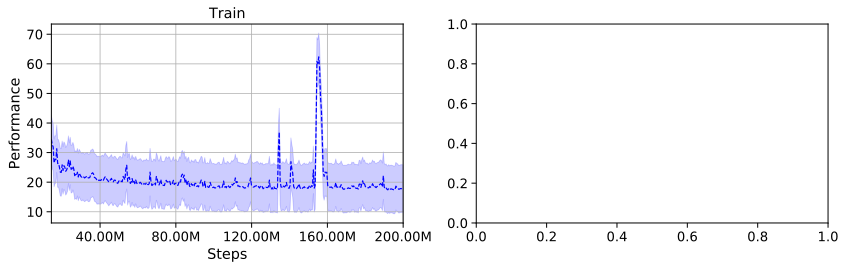

In [63]:
logs=pd.DataFrame(histogram)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4),sharey=False)
ax1.plot(logs['t'],logs['mean'],'--',color='blue')
ax1.fill_between(logs['t'],logs['mean']-logs['std'],logs['mean']+logs['std'],alpha=0.2,color='blue')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Performance')
ax1.set_title('Train')
ax1.set_xticks(np.linspace(0,2e8,6))
ax1.set_xlim([logs['t'].iloc[0],2e8])
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1e6) + 'M'))
ax1.grid()
fig.tight_layout()

In [64]:
logs=pd.DataFrame(histograms)
ax2.plot(logs['steps'],logs['mean'],'--',color='blue')
ax2.fill_between(logs['steps'],logs['mean']-logs['std'],logs['mean']+logs['std'],alpha=0.2,color='blue')
#p2t.fill_between(logs['steps'],logs['q1'],logs['q3'],alpha=0.1,color='blue')
#p2t.plot(logs['steps'],logs['mean'])
#ax2.set_ylabel('Performance')
ax2.set_xlabel('Steps')
ax2.set_title('Test')
ax2.set_xticks(np.linspace(0,2e8,6))
ax2.set_xlim([logs['steps'].iloc[0],2e8])
ax2.set_ylim(ax1.get_ylim())
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1e6) + 'M'))
ax2.grid()
fig.tight_layout()

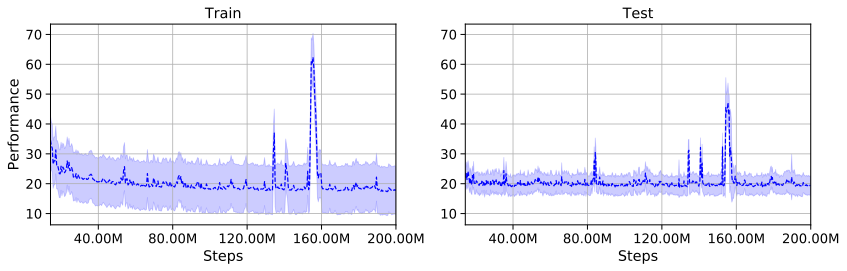

In [65]:
fig.savefig('performance.svg')
fig